## LSTM Advanced

https://www.kaggle.com/humamfauzi/multiple-stock-prediction-using-single-nn

In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas_datareader.data as web
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

### Load dataset

In [3]:
stock = ['^BFX', '^AEX', '^FCHI' ]
start = pd.to_datetime('2005-01-01')
df = web.DataReader(stock, data_source = 'yahoo', start = start)

In [4]:
df.isnull().values.any()
df.dropna(inplace=True)
df.isnull().values.any()

False

### Split train/test

In [5]:
data = df [['Close']]
data = data.reset_index()

training_data = data[:3057].copy()
test_data = data[3057:].copy()

training_data = training_data.set_index('Date')
test_data = test_data.set_index('Date')

In [6]:
df_train = {}
df_test = {}
for i in stock:
    df_train[i] = training_data.Close[i]
    df_test[i] = test_data.Close[i]

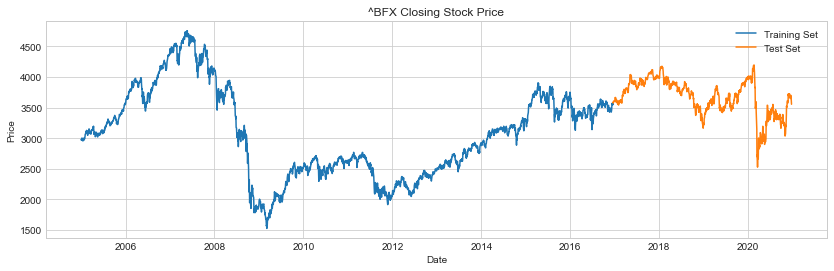

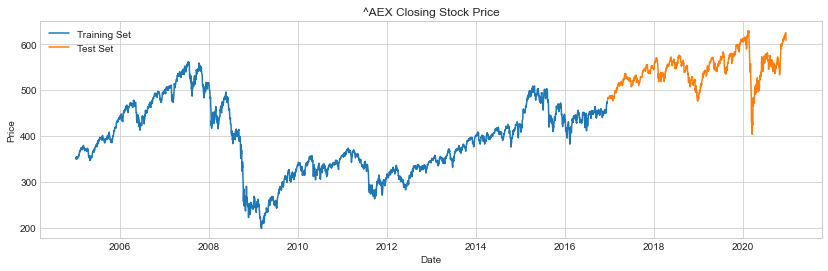

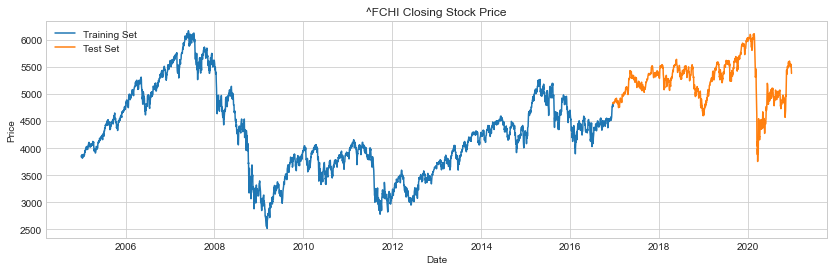

In [7]:
for i in stock:
    plt.figure(figsize=(14,4))
    plt.plot(df_train[i])
    plt.plot(df_test[i])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Closing Stock Price")

### Data normalization

In [8]:
# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(stock):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_train[i])
    a1 = np.array(df_test[i])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.transform(a1)
    scaler[i] = sc
    
del a0
del a1

In [9]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")    
for i in transform_test.keys():
    print(i, transform_test[i].shape)

^BFX (3057, 1)
^AEX (3057, 1)
^FCHI (3057, 1)


^BFX (1023, 1)
^AEX (1023, 1)
^FCHI (1023, 1)


### Shaping data for LSTM

In [10]:
trainset = {}
testset = {}
for j in stock:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(60,len(transform_train[j])):
        X_train.append(transform_train[j][i-60:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(60, len(transform_test[j])):
        X_test.append(transform_test[j][i-60:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

In [11]:
arr_buff = []
for i in stock:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=stock)

,X_train,y_train,X_test,y_test
^BFX,"(2997, 60, 1)","(2997,)","(963, 60, 1)","(963,)"
^AEX,"(2997, 60, 1)","(2997,)","(963, 60, 1)","(963,)"
^FCHI,"(2997, 60, 1)","(2997,)","(963, 60, 1)","(963,)"


### LSTM Network

In [100]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# Fitting to the training set
for i in stock:
    print("Fitting to", i)
    regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=20, batch_size=200)

Fitting to ^BFX
Epoch 1/20
2997/2997 [==============================] - 16s 5ms/step - loss: 0.0615
Epoch 2/20
2997/2997 [==============================] - 12s 4ms/step - loss: 0.0228
Epoch 3/20
2997/2997 [==============================] - 11s 4ms/step - loss: 0.0199
Epoch 4/20
2997/2997 [==============================] - 11s 4ms/step - loss: 0.0180
Epoch 5/20
2997/2997 [==============================] - 11s 4ms/step - loss: 0.0169
Epoch 6/20
2997/2997 [==============================] - 11s 4ms/step - loss: 0.0151
Epoch 7/20
2997/2997 [==============================] - 11s 4ms/step - loss: 0.0143
Epoch 8/20
2997/2997 [==============================] - 11s 4ms/step - loss: 0.0132
Epoch 9/20
2997/2997 [==============================] - 9s 3ms/step - loss: 0.0139
Epoch 10/20
2997/2997 [==============================] - 10s 3ms/step - loss: 0.0114
Epoch 11/20
2997/2997 [==============================] - 10s 3ms/step - loss: 0.0121
Epoch 12/20
2997/2997 [==============================] - 12

### Test data transformation & prediction

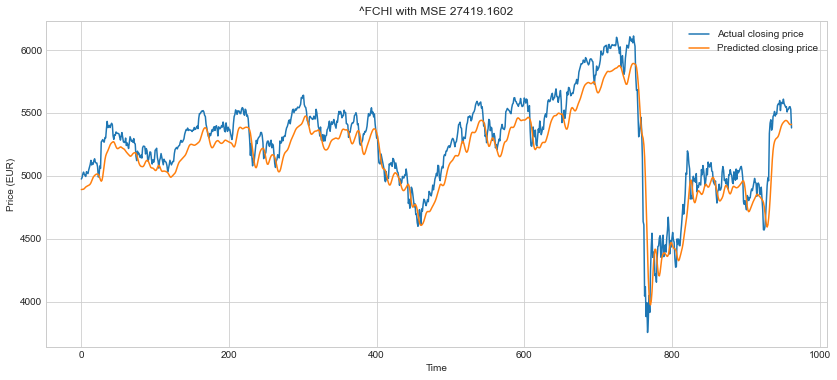

In [101]:
pred_result = {}
for i in stock:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
plt.figure(figsize=(14,6))
plt.title("^FCHI with MSE {:10.4f}".format(MSE))
plt.plot(pred_result['^FCHI']["True"], label = 'Actual closing price')
plt.plot(pred_result['^FCHI']["Pred"], label = 'Predicted closing price')
plt.xlabel('Time')
plt.ylabel('Price (EUR)')
plt.legend()

In [102]:
print(pred_result['^FCHI']["True"].mean())
print(pred_result['^FCHI']["Pred"].mean())
print(round((pred_result['^FCHI']["True"].mean()/pred_result['^FCHI']["Pred"].mean())*100,2))

5269.818467881944
5162.3887
102.08


### Lagging

In [103]:
time_index = df_test['^FCHI'][60:].index
def lagging(df, lag, value, time_index):
    df_pred = pd.Series(df["Pred"].reshape(-1), index=time_index)
    df_true = pd.Series(df["True"].reshape(-1), index=time_index)
    
    df_pred_lag = df_pred.shift(lag)
    df_pred_lag_price = df_pred.shift(lag) + value
    
    print("MSE without Lag:", mean_squared_error(np.array(df_true), np.array(df_pred)))
    print("MSE with Lag", lag, ":", mean_squared_error(np.array(df_true[:lag]), np.array(df_pred_lag[:lag])))
    print("MSE with Lag & moving price", value, ":", mean_squared_error(np.array(df_true[:lag]), np.array(df_pred_lag_price[:lag])))

    plt.figure(figsize=(14,4))
    plt.title("Prediction without Lag")
    plt.plot(df_true)
    plt.plot(df_pred)

    MSE_lag = mean_squared_error(np.array(df_true[:lag]), np.array(df_pred_lag[:lag]))
    plt.figure(figsize=(14,4))
    plt.title("Prediction with Lag")
    plt.plot(df_true)
    plt.plot(df_pred_lag)
    
    plt.figure(figsize=(14,4))
    plt.title("Prediction with Lag and moving price")
    plt.plot(df_true)
    plt.plot(df_pred_lag_price)

Shifting 7 days to the left and the price 300 euros down : 

MSE without Lag: 27419.160189628972
MSE with Lag -5 : 14666.67454749408
MSE with Lag & moving price 100 : 3709.463645875329


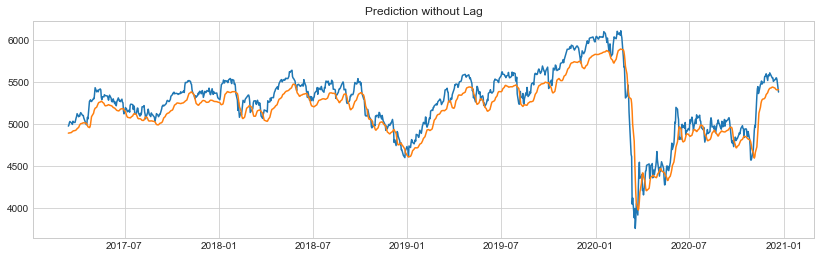

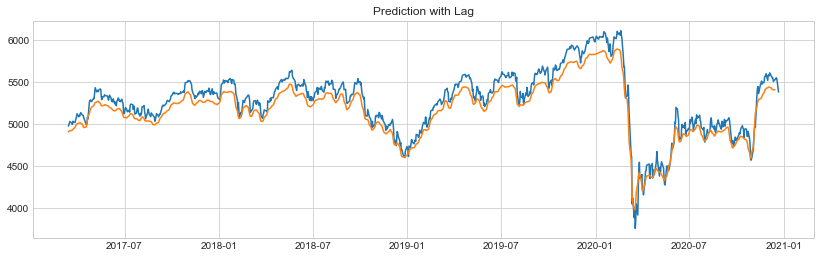

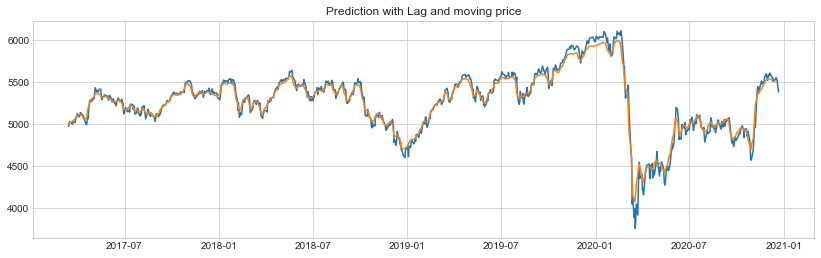

In [107]:
lagging(pred_result['^FCHI'], -5, 100, time_index)

When stock price is high, the MSE tend to get high but from the graph it predicts as good as the rest.

### Forecasting future stock

In [190]:
n = transform_test['^FCHI'].shape[0]
X_forecast=transform_test['^FCHI'][n-60:n+1,0]
X_forecast = np.array(X_forecast)
preds = []
n_days_ahead = 10
for i in range(0,n_days_ahead):
    X_forecast = np.reshape(X_forecast, (1, X_forecast.shape[0], 1))
    y_pred_scaled = regressor.predict(X_forecast)
    y_pred = scaler['^FCHI'].inverse_transform(y_pred_scaled)
    y_pred = np.reshape(y_pred, (np.shape(y_pred)[0]))
    y_pred_scaled = np.reshape(y_pred_scaled, (np.shape(y_pred_scaled)[0]))
    preds.append(y_pred)
    X_forecast = np.reshape(X_forecast, (X_forecast.shape[1]))
    X_forecast = np.concatenate((X_forecast, y_pred_scaled), axis=0)
    X_forecast = X_forecast[-60:]
    n = X_forecast.shape[0]

In [202]:
prediction = np.concatenate([pred_result['^FCHI']["Pred"],preds], axis=0)

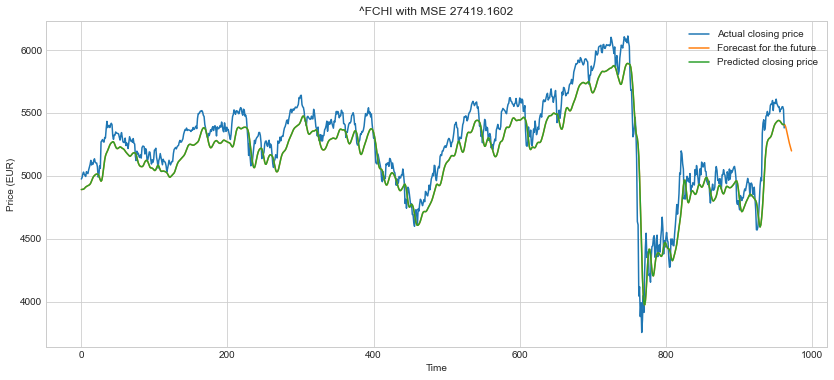

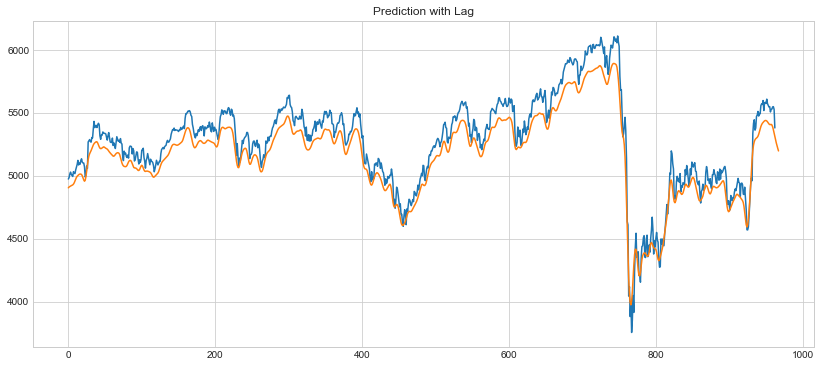

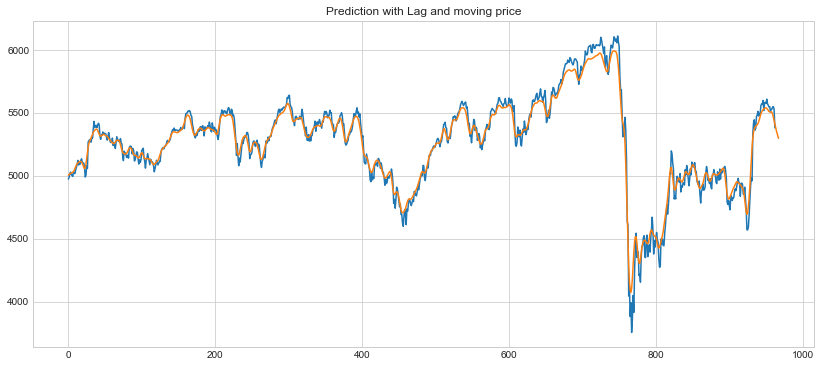

In [212]:
plt.figure(figsize=(14,6))
plt.title("^FCHI with MSE {:10.4f}".format(MSE))
plt.plot(pred_result['^FCHI']["True"], label = 'Actual closing price')
plt.plot(prediction, label = 'Forecast for the future')
plt.plot(pred_result['^FCHI']["Pred"], label = 'Predicted closing price')
plt.xlabel('Time')
plt.ylabel('Price (EUR)')
plt.legend()

df_true = pd.Series(pred_result['^FCHI']["True"].reshape(-1))
df_pred = pd.Series(prediction.reshape(-1))
df_pred_lag = df_pred.shift(-5)
df_pred_lag_price = df_pred.shift(-5) + 100

plt.figure(figsize=(14,6))
plt.title("Prediction with Lag")
plt.plot(df_true)
plt.plot(df_pred_lag)

plt.figure(figsize=(14,6))
plt.title("Prediction with Lag and moving price")
plt.plot(df_true)
plt.plot(df_pred_lag_price)